<!-- # Multi-modal RAG with LangChain -->

<!-- ## SetUp

Install the dependencies you need to run the notebook. -->

In [127]:
# for linux
# %sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [128]:
# %pip install -Uq "unstructured[all-docs]" pillow lxml pillow
# %pip install -Uq chromadb tiktoken
# %pip install -Uq langchain langchain-community langchain-openai langchain-groq
# %pip install -Uq python_dotenv

In [129]:
# import os

# # keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["GROQ_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

<!-- ## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc. -->

<!-- ### Partition PDF tables, text, and images -->

In [2]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = "p2.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,  # extract tables
    strategy="hi_res",  # mandatory to infer tables
    extract_image_block_types=[
        "Image"
    ],  # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64
    extract_image_block_to_payload=True,  # if true, will extract base64 for API usage
    chunking_strategy="by_title",  # or 'basic'
    # max_characters=4000,                  # defaults to 500
    # combine_text_under_n_chars=1000,       # defaults to 0
    # new_after_n_chars=2000,
    # extract_images_in_pdf=True,          # deprecated
)

In [3]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>",
 "<class 'unstructured.documents.elements.Table'>",
 "<class 'unstructured.documents.elements.TableChunk'>"}

In [4]:
len(chunks)

223

In [5]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

In [6]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if "Image" in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'da486b29-3667-436d-9281-4d13f7bb9415',
 'text': 'Your Policy Number       :  Your Customer ID          :  0000000046362705  0000000082193055-01  What your policy covers?  •    Hospitalization Cover  •     Pre-Hospitalization of 30 days  •    Post hospitalization of 60 days ',
 'metadata': {'detection_class_prob': 0.2803719639778137,
  'coordinates': {'points': ((95.85321807861328, 1405.35400390625),
    (95.85321807861328, 1627.3935546875),
    (1188.888427734375, 1627.3935546875),
    (1188.888427734375, 1405.35400390625)),
   'system': 'PixelSpace',
   'layout_width': 1653,
   'layout_height': 2339},
  'last_modified': '2024-12-11T15:36:22',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADeBEUDASIAAh

<!-- ### Separate extracted elements into tables, text, and images -->

In [7]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [8]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64


images = get_images_base64(chunks)

<!-- #### Check what the images look like -->

In [9]:
import base64
from IPython.display import Image, display


def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


# display_base64_image(images[0])

<!-- ## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process. -->

<!-- ### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq. -->

In [10]:
# %pip install -Uq langchain-groq

In [48]:
# from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [12]:
# # Prompt
# prompt_text = """
# You are an assistant tasked with summarizing tables and text.
# Give a concise summary of the table or text.

# Respond only with the summary, no additionnal comment.
# Do not start your message by saying "Here is a summary" or anything like that.
# Just give the summary as it is.

# Table or text chunk: {element}

# """
# prompt = ChatPromptTemplate.from_template(prompt_text)

# # Summary chain
# model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
# summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [13]:
# Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [14]:
# text_summaries

<!-- ### Image summaries

We will use gpt-4o-mini to produce the image summaries. -->

In [15]:
# %pip install -Uq langchain_openai

In [16]:
# from langchain_openai import ChatOpenAI

# prompt_template = """Describe the image in detail. For context,
#                   the image is part of a research paper explaining the transformers
#                   architecture. Be specific about graphs, such as bar plots."""
# messages = [
#     (
#         "user",
#         [
#             {"type": "text", "text": prompt_template},
#             {
#                 "type": "image_url",
#                 "image_url": {"url": "data:image/jpeg;base64,{image}"},
#             },
#         ],
#     )
# ]

# prompt = ChatPromptTemplate.from_messages(messages)

# chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


# image_summaries = chain.batch(images)

In [17]:
# image_summaries

In [18]:
# print(image_summaries[1])

<!-- ## Load data and summaries to vectorstore -->

<!-- ### Create the vectorstore -->

In [20]:
import uuid

import faiss
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore

from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.vectorstores import FAISS

# The storage layer for the parent documents
store = InMemoryDocstore()
id_key = "doc_id"

# Load Hugging Face embeddings (e.g., from sentence-transformers)
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
# "sentence-transformers/all-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model)

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))


# The vectorstore to use FAISS for indexing
vectorstore = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=store,
    index_to_docstore_id={},
)
# vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)


# The retriever (empty to start)
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     docstore=store,
#     id_key=id_key,
# )


# # Example: Adding a document to the retriever
# doc_id = str(uuid.uuid4())
# document = Document(
#     page_content="Example document content", metadata={"source": "example"}
# )
# vectorstore.add_texts(
#     [document.page_content], metadatas=[document.metadata], ids=[doc_id]
# )
# store.mset({doc_id: document})

In [21]:
# import uuid
# from langchain.vectorstores import Chroma
# from langchain.storage import InMemoryStore
# from langchain.schema.document import Document
# from langchain.embeddings import OpenAIEmbeddings
# from langchain.retrievers.multi_vector import MultiVectorRetriever

# # The vectorstore to use to index the child chunks
# vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# # The storage layer for the parent documents
# store = InMemoryStore()
# id_key = "doc_id"

# # The retriever (empty to start)
# retriever = MultiVectorRetriever(
#     vectorstore=vectorstore,
#     docstore=store,
#     id_key=id_key,
# )

<!-- ### Load the summaries and link the to the original data -->

In [22]:
text_doc_ids = [str(uuid.uuid4()) for _ in texts]

text_documents = [
    Document(page_content=summary.text, metadata={id_key: text_doc_ids[i]})
    for i, summary in enumerate(texts)
]


tables_html = [table.metadata.text_as_html for table in tables]
table_doc_ids = [str(uuid.uuid4()) for _ in tables_html]
table_documents = [
    Document(page_content=summary, metadata={id_key: table_doc_ids[i]})
    for i, summary in enumerate(tables_html)
]

In [23]:
tables_html

['<table><tr><td>Proposer Name</td><td>SAMBIT KUMAR</td><td>PATRA</td></tr><tr><td>Address</td><td>SAMBIT Odisha - 754029, India.</td><td>PATRA,RAMPEL,,Arakhapatna,Cuttack, Cuttack,</td></tr><tr><td>Period of Insurance</td><td>From: 11/11/2023</td><td>(00:00)Hrs To: Midnight of 10/11/2024</td></tr><tr><td>PAN No.</td></tr><tr><td>Premium Frequency</td><td>Yearly</td><td/></tr><tr><td>Date of inception first insurance policy</td><td>11/11/2021</td><td/></tr><tr><td>Cover Opted</td><td>Family Floater</td><td/></tr><tr><td>Previous Policy No. (if any)</td><td>POASANO0100022634</td><td/></tr><tr><td>Nominee (Name, Age &amp; Relationship)</td><td>LOPAMUDRA BASTIA_</td><td>,28</td></tr><tr><td>Nominee (Name, Age &amp; Relationship)</td><td>LOPAMUDRA BASTIA_</td><td>,28</td></tr></table>',
 '<table><tr><td>Nominee (Name, Age &amp; Relationship)</td><td>LOPAMUDRA BASTIA</td><td>,28</td></tr><tr><td>Appointee (Name &amp; Relationship), if any</td></tr><tr><td>Appointee (Name &amp; Relationship)

In [24]:
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})
retriever.vectorstore.add_documents(documents=text_documents, ids=text_doc_ids)
retriever.vectorstore.add_documents(documents=table_documents, ids=table_doc_ids)
# retriever.vectorstore.add_documents(summary_tables)

['c9c485cc-feab-41f5-8f47-abf0ad363a94',
 '25384c2c-1930-4cde-9038-7ed9ef1a5790',
 'a0a17b13-9086-4e4e-9fd3-14a5a0e00422',
 '5189fbf0-adc9-4d97-aaf2-e9d5d1863414',
 '827bd38c-0e62-4a59-80a7-459d7c4c1a81',
 'f309334a-74a7-4150-afa8-2723fe6a9aca',
 '640029de-5d2c-4839-8eee-ea1c35038d0d',
 '9069a951-8f25-48e6-80a2-409bae5c915e',
 'acc82990-0b2e-4367-99d3-960c1abfcb55',
 'd883f6e3-62cc-4906-9953-63b96ea127fd',
 '419e6ad5-bfc5-4c5b-9af0-78c002cdf8fe']

In [25]:
# retriever.invoke("TABLE OF BENEFITS")

In [26]:
# retriever.docstore.mset(list(zip(table_ids, tables)))

# # Add image summaries
# img_ids = [str(uuid.uuid4()) for _ in images]
# summary_img = [
#     Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
# ]
# retriever.vectorstore.add_documents(summary_img)
# retriever.docstore.mset(list(zip(img_ids, images)))

<!-- ### Check retrieval -->

In [27]:
# # Retrieve
# docs = retriever.invoke(
#     "who are the authors of the paper?"
# )

In [28]:
# for doc in docs:
#     print(str(doc) + "\n\n" + "-" * 80)

<!-- ## RAG pipeline -->

In [30]:
from langchain_huggingface import HuggingFacePipeline
from transformers import pipeline

def initialize_llm(
    model_id="google/gemma-1.1-2b-it",
    pipeline_kwargs={
        "max_new_tokens": 100,
        "top_k": 50,
        "temperature": 0.5,
        "do_sample": True,
        "device": "cpu",
    },
):
    """Initializes Hugging Face LLM pipeline."""
    hf_pipeline = pipeline(task="text-generation", model=model_id, **pipeline_kwargs)
    return HuggingFacePipeline(pipeline=hf_pipeline)

llm = initialize_llm()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu


In [31]:
from langchain_huggingface import ChatHuggingFace


def chat_bot_llm(llm):
    chat_model = ChatHuggingFace(llm=llm)
    return chat_model

chat_llm = chat_bot_llm(llm=llm)

In [43]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

from langchain_core.messages import SystemMessage, HumanMessage

from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.page_content

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    # if len(docs_by_type["images"]) > 0:
    #     for image in docs_by_type["images"]:
    #         prompt_content.append(
    #             {
    #                 "type": "image_url",
    #                 "image_url": {"url": f"data:image/jpeg;base64,{image}"},
    #             }
    #         )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | chat_llm
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(RunnableLambda(build_prompt) | llm | StrOutputParser())
)

In [44]:
question = "What is the list of insured members?"

In [45]:
docs = retriever.invoke(question)

In [46]:
context = parse_docs(docs)


In [53]:
prompt = build_prompt({"context": context, "question": question})
print(prompt)

input_variables=[] input_types={} partial_variables={} messages=[HumanMessage(content=[{'type': 'text', 'text': '\n    Answer the question based only on the following context, which can include text, tables.\n    Context: 4. COVERAGE\n\nThe covers listed below are in-built Policy benefits and shall be available to all Insured Persons in accordance with the procedures set out in this Policy.\n    Question: What is the list of insured members?\n    '}], additional_kwargs={}, response_metadata={})]


In [ ]:
llm_res = chat_llm(prompt.messages)
llm_res

In [33]:
response = chain.invoke("List of insured members")

print(response)
print(response["response"])

AttributeError: 'Document' object has no attribute 'text'

Response: Multi-head attention is a mechanism used in the Transformer model that allows the model to focus on different parts of the input sequence simultaneously. Instead of using a single attention function, multi-head attention uses multiple attention heads, each performing attention with different, learned linear projections of the queries, keys, and values. 

Here's a breakdown of how it works:

1. **Linear Projections**: The queries (Q), keys (K), and values (V) are projected into different subspaces using learned linear transformations. Each head has its own set of projections.

2. **Parallel Attention**: Each head computes attention independently, allowing the model to attend to various representation subspaces from different positions in the input sequence.

3. **Concatenation**: The outputs from all heads are concatenated together.

4. **Final Linear Projection**: The concatenated output is then projected again to produce the final output.

This approach enables the model to 

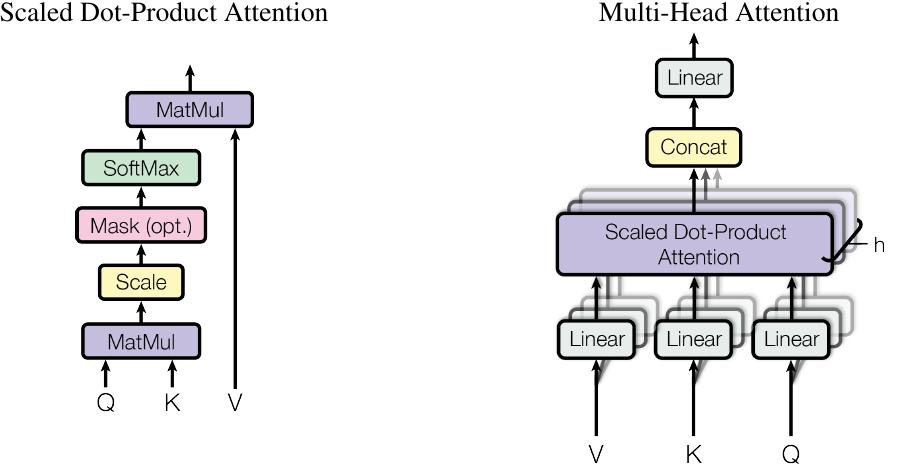

In [ ]:
response = chain_with_sources.invoke("What is multihead?")

print("Response:", response["response"])

print("\n\nContext:")
for text in response["context"]["texts"]:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-" * 50 + "\n")
for image in response["context"]["images"]:
    display_base64_image(image)

<!-- ## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/) -->